In [1]:
import pandas as pd

In [2]:
df_driver_ids = pd.read_csv('datasets/Lyft/driver_ids.csv')
df_driver_ids['driver_onboard_date'] = pd.to_datetime(df_driver_ids['driver_onboard_date'])
df_driver_ids.head(2)

,driver_id,driver_onboard_date
0,002be0ffdc997bd5c50703158b7c2491,2016-03-29
1,007f0389f9c7b03ef97098422f902e62,2016-03-29


array([[<Axes: title={'center': 'driver_onboard_date'}>]], dtype=object)

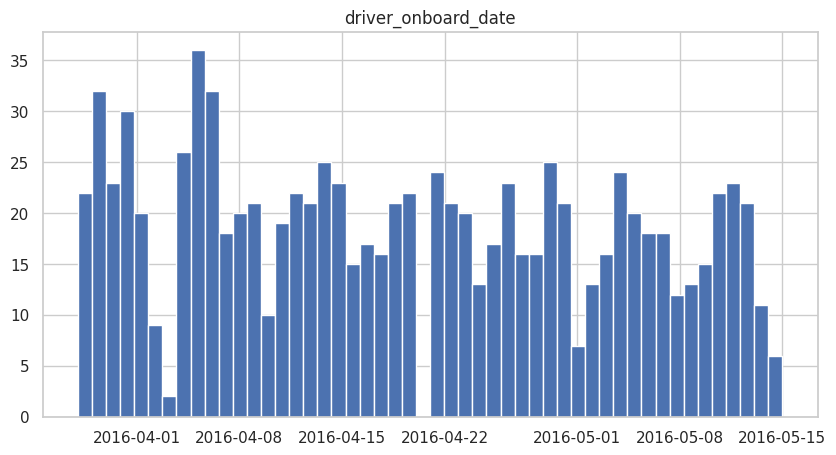

In [137]:
df_driver_ids.hist(column='driver_onboard_date', bins=50, figsize=(10, 5))

In [3]:
df_ride_ids = pd.read_csv('datasets/Lyft/ride_ids.csv')
# convert rider_duration from seconds to minutes
df_ride_ids['ride_duration'] = df_ride_ids['ride_duration'] / 60
# convert ride_distance from meters to miles
df_ride_ids['ride_distance'] = df_ride_ids['ride_distance'] * 0.000621371
df_ride_ids.head(2)

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1.125303,5.450000,50
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,2.089049,13.483333,0


In [4]:
df_ride_timestamps = pd.read_csv('datasets/Lyft/ride_timestamps.csv')
df_ride_timestamps['timestamp'] = pd.to_datetime(df_ride_timestamps['timestamp'])  # .dt.floor('d')
# df_ride_timestamps = pd.merge(df_ride_timestamps, df_ride_ids[['ride_id', 'driver_id']], on='ride_id', how='left')
print(df_ride_timestamps.shape)
df_ride_timestamps.head(2)

(970405, 3)


,ride_id,event,timestamp
0,00003037a262d9ee40e61b5c0718f7f0,requested_at,2016-06-13 09:39:19
1,00003037a262d9ee40e61b5c0718f7f0,accepted_at,2016-06-13 09:39:51


In [5]:
df_ride_ids_timestamps = pd.merge(df_ride_ids, df_ride_timestamps[['ride_id', 'event', 'timestamp']], on='ride_id', how='inner', validate='one_to_many')
df_last_ride = df_ride_ids_timestamps.groupby('driver_id')['timestamp'].max().reset_index().rename(columns={'timestamp': 'last_ride_date'})
df_last_ride['last_ride_date'] = df_last_ride['last_ride_date'].dt.floor('d')
df_lifetime = pd.merge(df_driver_ids, df_last_ride, on='driver_id', how='inner', validate='one_to_one')
df_lifetime['lifetime_days'] = (df_lifetime['last_ride_date'] - df_lifetime['driver_onboard_date']).dt.days
df_lifetime.head(2)

,driver_id,driver_onboard_date,last_ride_date,lifetime_days
0,002be0ffdc997bd5c50703158b7c2491,2016-03-29,2016-06-23,86
1,007f0389f9c7b03ef97098422f902e62,2016-03-29,2016-06-22,85


In [6]:
# pivot df_ride_timestamps['event'] to columns with timestamp as values
df_ride_timestamps_pivot = df_ride_timestamps.pivot(index='ride_id', columns='event', values='timestamp').reset_index()
df_ride_timestamps_pivot.columns.name = None
df_ride_timestamps_pivot = pd.merge(df_ride_timestamps_pivot, df_ride_ids[['ride_id', 'driver_id']], on='ride_id', how='left')
df_ride_timestamps_pivot.head(2)

,ride_id,accepted_at,arrived_at,dropped_off_at,picked_up_at,requested_at,driver_id
0,00003037a262d9ee40e61b5c0718f7f0,2016-06-13 09:39:51,2016-06-13 09:44:31,2016-06-13 10:03:05,2016-06-13 09:44:33,2016-06-13 09:39:19,d967f5296732fa55266b5f1314e7447b
1,00005eae40882760d675da5effb89ae3,2016-05-14 05:23:25,2016-05-14 05:26:17,2016-05-14 05:34:17,2016-05-14 05:26:18,2016-05-14 05:23:21,0656192a402808805282e60761bda088


In [7]:
df_ride_timestamps_pivot['request_to_accept'] = (df_ride_timestamps_pivot['accepted_at'] - df_ride_timestamps_pivot['requested_at']).dt.total_seconds() / 60
df_ride_timestamps_pivot['accept_to_arrive'] = (df_ride_timestamps_pivot['arrived_at'] - df_ride_timestamps_pivot['accepted_at']).dt.total_seconds() / 60
df_ride_timestamps_pivot['arrive_to_pickup'] = (df_ride_timestamps_pivot['picked_up_at'] - df_ride_timestamps_pivot['arrived_at']).dt.total_seconds() / 60
df_ride_timestamps_pivot.head(2)

,ride_id,accepted_at,arrived_at,dropped_off_at,picked_up_at,requested_at,driver_id,request_to_accept,accept_to_arrive,arrive_to_pickup
0,00003037a262d9ee40e61b5c0718f7f0,2016-06-13 09:39:51,2016-06-13 09:44:31,2016-06-13 10:03:05,2016-06-13 09:44:33,2016-06-13 09:39:19,d967f5296732fa55266b5f1314e7447b,0.533333,4.666667,0.033333
1,00005eae40882760d675da5effb89ae3,2016-05-14 05:23:25,2016-05-14 05:26:17,2016-05-14 05:34:17,2016-05-14 05:26:18,2016-05-14 05:23:21,0656192a402808805282e60761bda088,0.066667,2.866667,0.016667


In [8]:
# find the average request_to_accept, accept_to_arrive, arrive_to_pickup time for each driver
df_driver_avg_ride_intervals = df_ride_timestamps_pivot.groupby('driver_id')[['request_to_accept', 'accept_to_arrive', 'arrive_to_pickup']].mean().reset_index()
df_driver_avg_ride_intervals.rename(columns={'request_to_accept': 'avg_request_to_accept', 'accept_to_arrive': 'avg_accept_to_arrive', 'arrive_to_pickup': 'avg_arrive_to_pickup'}, inplace=True)
df_driver_avg_ride_intervals

,driver_id,avg_request_to_accept,avg_accept_to_arrive,avg_arrive_to_pickup
0,002be0ffdc997bd5c50703158b7c2491,0.140132,2.883153,0.087184
1,007f0389f9c7b03ef97098422f902e62,0.197312,2.952688,0.081183
2,011e5c5dfc5c2c92501b8b24d47509bc,0.121569,3.720588,0.068137
3,0152a2f305e71d26cc964f8d4411add9,0.236649,3.908813,0.091885
4,01674381af7edd264113d4e6ed55ecda,0.208800,3.608133,0.136800
...,...,...,...,...
839,ff419a3476e21e269e340b5f1f05414e,0.218939,4.651997,0.114738
840,ff714a67ba8c6a108261cd81e3b77f3a,0.177663,2.976426,0.048144
841,fff482c704d36a1afe8b8978d5486283,0.303333,3.835238,0.034762
842,fffecccc49436c5389075b13209f0dfa,0.176929,3.572619,0.191051


In [9]:
# calculate the average acceptance rate (accepted_at - requested_at) per driver per ride


In [10]:
# calculate the number of rides per driver
df_ride_count = df_ride_ids.groupby('driver_id')['ride_id'].count().reset_index().rename(columns={'ride_id': 'ride_count'})
df_ride_count.head(2)

,driver_id,ride_count
0,002be0ffdc997bd5c50703158b7c2491,277
1,007f0389f9c7b03ef97098422f902e62,31


In [11]:
# calculate the average distance per driver per ride
df_ride_distance = df_ride_ids.groupby('driver_id')['ride_distance'].mean().reset_index().rename(columns={'ride_distance': 'avg_ride_distance'})
df_ride_distance.head(2)

,driver_id,avg_ride_distance
0,002be0ffdc997bd5c50703158b7c2491,3.903841
1,007f0389f9c7b03ef97098422f902e62,2.355818


In [12]:
# calculate the average prime time per driver per ride
df_ride_prime_time = df_ride_ids.groupby('driver_id')['ride_prime_time'].mean().reset_index().rename(columns={'ride_prime_time': 'avg_ride_prime_time'})
df_ride_prime_time.head(2)

,driver_id,avg_ride_prime_time
0,002be0ffdc997bd5c50703158b7c2491,19.404332
1,007f0389f9c7b03ef97098422f902e62,20.161290


In [15]:
df_lifetime

,driver_id,driver_onboard_date,last_ride_date,lifetime_days
0,002be0ffdc997bd5c50703158b7c2491,2016-03-29,2016-06-23,86
1,007f0389f9c7b03ef97098422f902e62,2016-03-29,2016-06-22,85
2,011e5c5dfc5c2c92501b8b24d47509bc,2016-04-05,2016-06-12,68
3,0152a2f305e71d26cc964f8d4411add9,2016-04-23,2016-06-26,64
4,01674381af7edd264113d4e6ed55ecda,2016-04-29,2016-06-24,56
...,...,...,...,...
832,ff419a3476e21e269e340b5f1f05414e,2016-04-26,2016-06-26,61
833,ff714a67ba8c6a108261cd81e3b77f3a,2016-03-28,2016-06-17,81
834,fff482c704d36a1afe8b8978d5486283,2016-04-08,2016-05-12,34
835,fffecccc49436c5389075b13209f0dfa,2016-05-06,2016-06-26,51


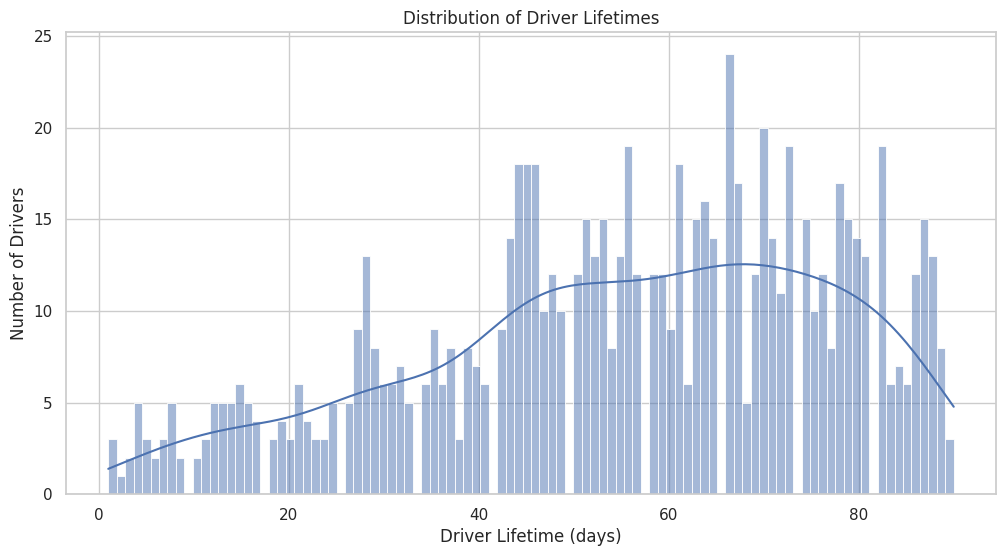

In [16]:
# plot the distribution of driver lifetimes
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
plt.figure(figsize=(12, 6))
sns.histplot(df_lifetime['lifetime_days'], bins=100, kde=True)
plt.title('Distribution of Driver Lifetimes')
plt.xlabel('Driver Lifetime (days)')
plt.ylabel('Number of Drivers')
plt.show()

In [17]:
def value_of_ride(ride_distance, ride_duration, ride_prime_time):
    cost = 1.15 * ride_distance + 0.22 * (ride_duration) + 1.75 + 2.00 * ((1+ride_prime_time)/100)
    # the maximum cost of a ride is 400 and the minimum cost is 5
    if cost > 400:
        cost = 400
    elif cost < 5:
        cost = 5
    return cost

In [18]:
df_ride_ids['value_of_ride'] = df_ride_ids.apply(lambda x: value_of_ride(x['ride_distance'], x['ride_duration'], x['ride_prime_time']), axis=1)
df_ride_ids.head(2)

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,value_of_ride
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1.125303,5.450000,50,5.263098
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,2.089049,13.483333,0,7.138740


In [19]:
# groupby driver_id and get the average cost of ride
df_avg_value_of_ride = df_ride_ids.groupby('driver_id')['value_of_ride'].mean().reset_index().rename(columns={'value_of_ride': 'avg_value_of_ride'})
df_avg_value_of_ride.head(2)

,driver_id,avg_value_of_ride
0,002be0ffdc997bd5c50703158b7c2491,9.700850
1,007f0389f9c7b03ef97098422f902e62,7.434851


In [20]:
df_lifetime_value = df_ride_ids.groupby('driver_id')['value_of_ride'].sum().reset_index().rename(columns={'value_of_ride': 'lifetime_value'})
df_lifetime_value.head(2)

,driver_id,lifetime_value
0,002be0ffdc997bd5c50703158b7c2491,2687.135387
1,007f0389f9c7b03ef97098422f902e62,230.480383


In [21]:
df_lifetime

,driver_id,driver_onboard_date,last_ride_date,lifetime_days
0,002be0ffdc997bd5c50703158b7c2491,2016-03-29,2016-06-23,86
1,007f0389f9c7b03ef97098422f902e62,2016-03-29,2016-06-22,85
2,011e5c5dfc5c2c92501b8b24d47509bc,2016-04-05,2016-06-12,68
3,0152a2f305e71d26cc964f8d4411add9,2016-04-23,2016-06-26,64
4,01674381af7edd264113d4e6ed55ecda,2016-04-29,2016-06-24,56
...,...,...,...,...
832,ff419a3476e21e269e340b5f1f05414e,2016-04-26,2016-06-26,61
833,ff714a67ba8c6a108261cd81e3b77f3a,2016-03-28,2016-06-17,81
834,fff482c704d36a1afe8b8978d5486283,2016-04-08,2016-05-12,34
835,fffecccc49436c5389075b13209f0dfa,2016-05-06,2016-06-26,51


In [26]:
df_driver = pd.merge(df_avg_value_of_ride, df_lifetime[['driver_id', 'lifetime_days']], on='driver_id', how='inner', validate='one_to_one')
df_driver = pd.merge(df_driver, df_lifetime_value, on='driver_id', how='left', validate='one_to_one')
df_driver = pd.merge(df_driver, df_ride_count, on='driver_id', how='left', validate='one_to_one')
df_driver = pd.merge(df_driver, df_ride_distance, on='driver_id', how='left', validate='one_to_one')
df_driver = pd.merge(df_driver, df_ride_prime_time, on='driver_id', how='left', validate='one_to_one')
df_driver = pd.merge(df_driver, df_driver_avg_ride_intervals, on='driver_id', how='left', validate='one_to_one')
df_driver['ride_count_per_day'] = df_driver['ride_count'] / df_driver['lifetime_days']
df_driver.drop(columns=['ride_count'], inplace=True)
df_driver.set_index('driver_id', inplace=True, drop=True)
# calculate the average value of a driver
print('Average value of a driver: ', df_driver['lifetime_value'].mean())
# calculate the average lifetime of a driver
print('Average lifetime of a driver: ', df_driver['lifetime_days'].mean())
df_driver

Average value of a driver:  2279.6216486084622
Average lifetime of a driver:  55.10513739545998


,avg_value_of_ride,lifetime_days,lifetime_value,avg_ride_distance,avg_ride_prime_time,avg_request_to_accept,avg_accept_to_arrive,avg_arrive_to_pickup,ride_count_per_day
driver_id,,,,,,,,,
002be0ffdc997bd5c50703158b7c2491,9.700850,86,2687.135387,3.903841,19.404332,0.140132,2.883153,0.087184,3.220930
007f0389f9c7b03ef97098422f902e62,7.434851,85,230.480383,2.355818,20.161290,0.197312,2.952688,0.081183,0.364706
011e5c5dfc5c2c92501b8b24d47509bc,11.086598,68,376.944322,4.928075,19.852941,0.121569,3.720588,0.068137,0.500000
0152a2f305e71d26cc964f8d4411add9,11.000113,64,2101.021553,4.786310,10.732984,0.236649,3.908813,0.091885,2.984375
01674381af7edd264113d4e6ed55ecda,11.556040,56,4333.514947,5.175845,12.533333,0.208800,3.608133,0.136800,6.696429
...,...,...,...,...,...,...,...,...,...
ff419a3476e21e269e340b5f1f05414e,11.782195,61,2851.291070,5.141460,12.809917,0.218939,4.651997,0.114738,3.967213
ff714a67ba8c6a108261cd81e3b77f3a,9.787351,81,4746.865363,3.631837,17.783505,0.177663,2.976426,0.048144,5.987654
fff482c704d36a1afe8b8978d5486283,8.532798,34,298.647921,3.096096,5.000000,0.303333,3.835238,0.034762,1.029412


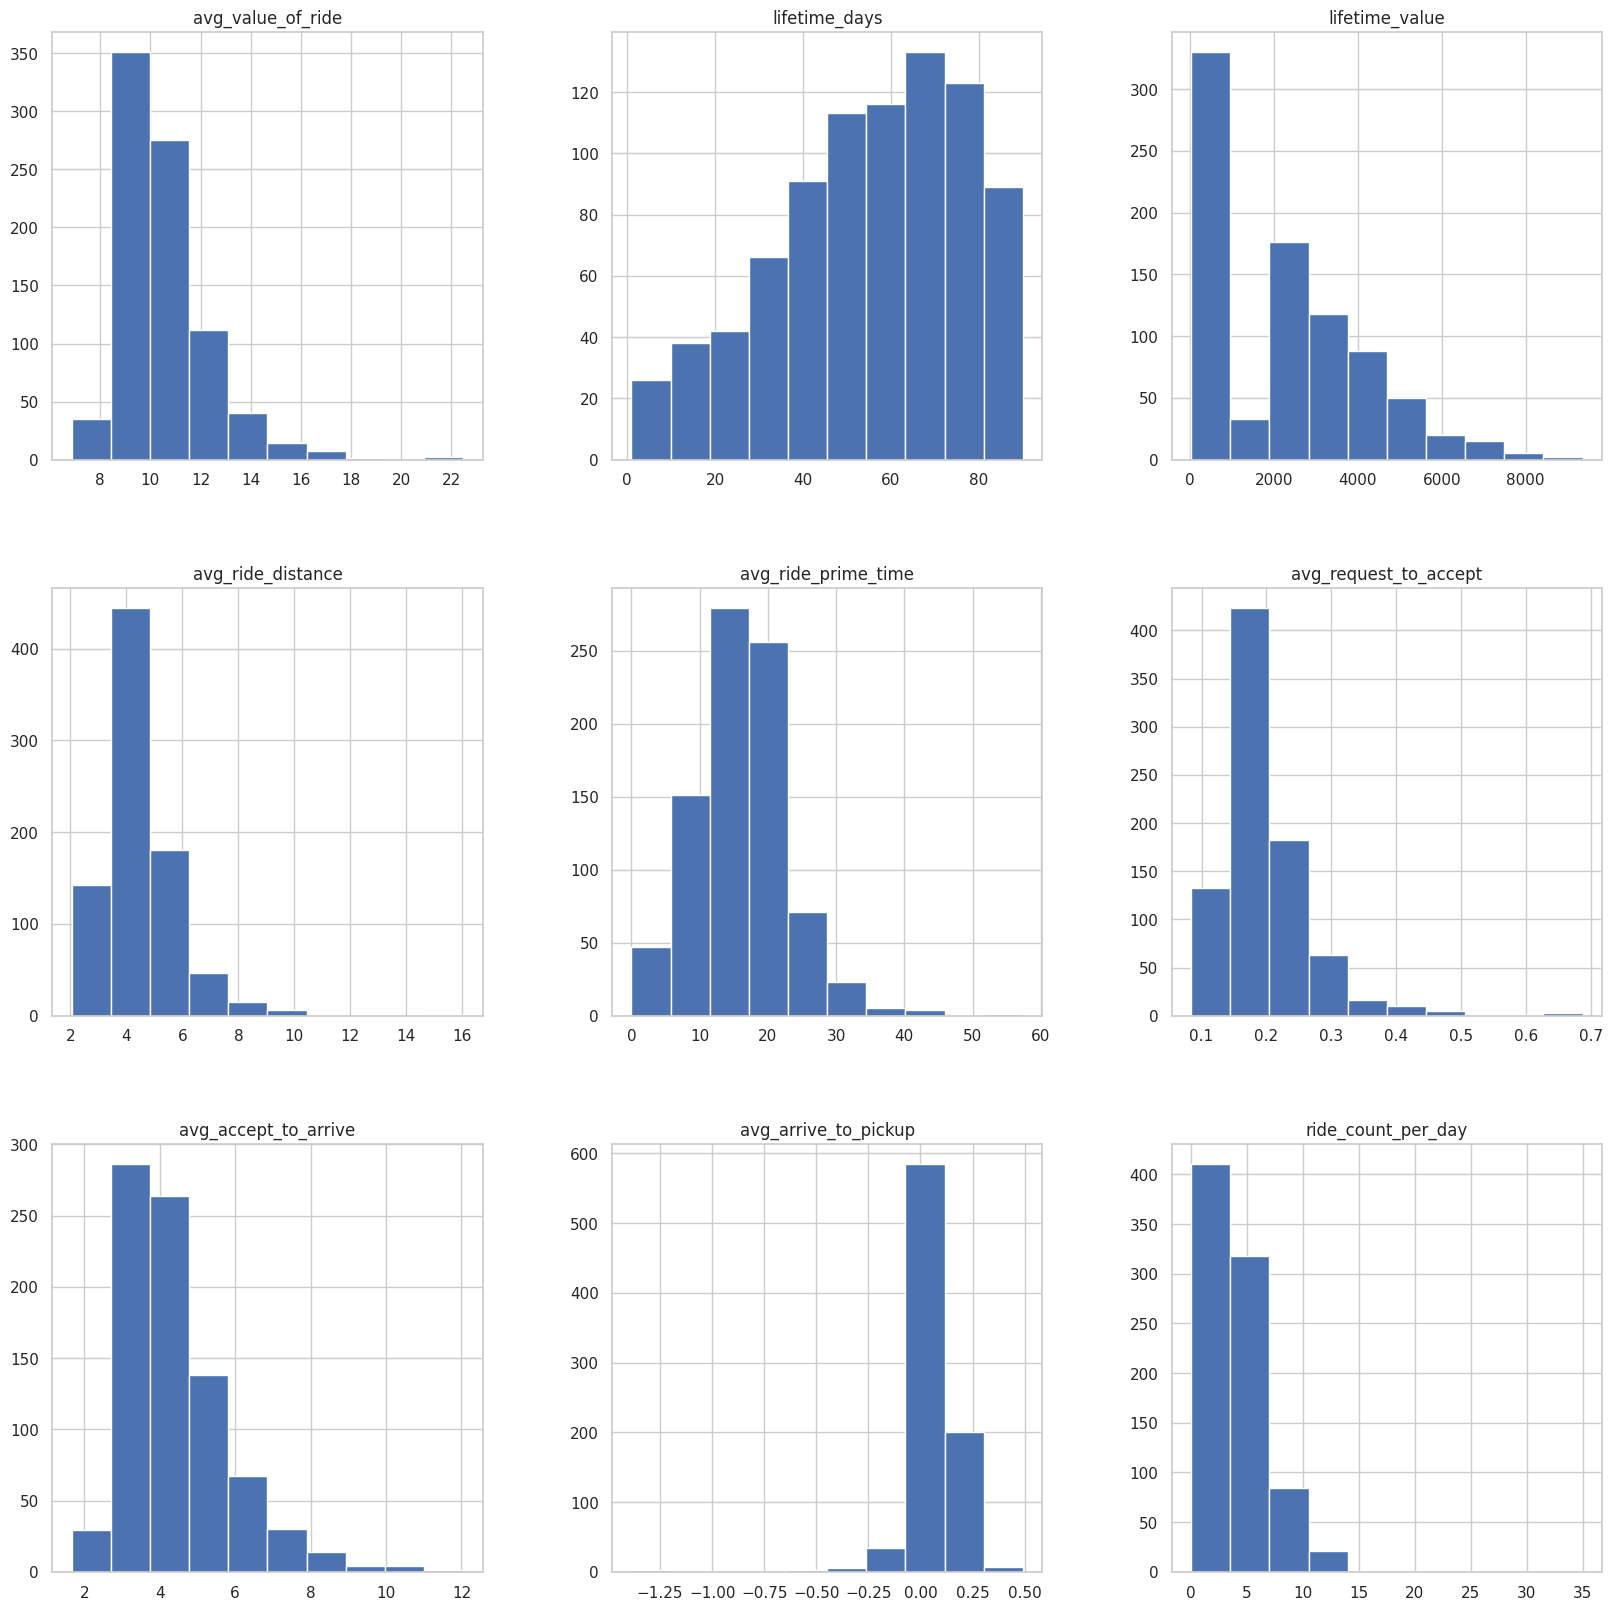

In [27]:
# plot the distributions of all `df_driver` features
df_driver.hist(figsize=(20, 20))
plt.show()

In [28]:
print(list(df_driver.columns))

['avg_value_of_ride', 'lifetime_days', 'lifetime_value', 'avg_ride_distance', 'avg_ride_prime_time', 'avg_request_to_accept', 'avg_accept_to_arrive', 'avg_arrive_to_pickup', 'ride_count_per_day']


In [120]:
cols_min_max_scale = ['lifetime_value', 'avg_value_of_ride', 'avg_ride_distance', 'avg_ride_prime_time', 'avg_request_to_accept', 'avg_accept_to_arrive', 'avg_arrive_to_pickup', 'ride_count_per_day']
# min-max scale the features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_driver_scaled = df_driver.copy()
df_driver_scaled[cols_min_max_scale] = scaler.fit_transform(df_driver[cols_min_max_scale])
df_driver_scaled = df_driver_scaled[cols_min_max_scale]
df_driver_scaled.head(2)

,lifetime_value,avg_value_of_ride,avg_ride_distance,avg_ride_prime_time,avg_request_to_accept,avg_accept_to_arrive,avg_arrive_to_pickup,ride_count_per_day
driver_id,,,,,,,,
002be0ffdc997bd5c50703158b7c2491,0.285478,0.181751,0.132614,0.338135,0.092900,0.117093,0.784625,0.090809
007f0389f9c7b03ef97098422f902e62,0.022358,0.036590,0.021907,0.351325,0.187658,0.123794,0.781431,0.009093


In [121]:
# # standardize the features
# cols_min_max_scale = ['lifetime_value', 'avg_value_of_ride', 'avg_ride_distance', 'avg_ride_prime_time', 'avg_request_to_accept', 'avg_accept_to_arrive', 'avg_arrive_to_pickup', 'ride_count_per_day']
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# df_driver_scaled = df_driver.copy()
# df_driver_scaled[cols_min_max_scale] = scaler.fit_transform(df_driver[cols_min_max_scale])
# df_driver_scaled = df_driver_scaled[cols_min_max_scale]
# df_driver_scaled.head(2)

In [122]:
df_driver_scaled.describe()

,lifetime_value,avg_value_of_ride,avg_ride_distance,avg_ride_prime_time,avg_request_to_accept,avg_accept_to_arrive,avg_arrive_to_pickup,ride_count_per_day
count,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000
mean,0.241831,0.234155,0.173619,0.282269,0.189653,0.264955,0.772672,0.113196
std,0.197495,0.109299,0.093367,0.119125,0.114822,0.135528,0.067874,0.090198
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.049465,0.164127,0.113162,0.206931,0.123720,0.172521,0.756604,0.038973
50%,0.238069,0.207386,0.149730,0.282122,0.166275,0.234822,0.769641,0.101903
75%,0.370550,0.281504,0.213182,0.347153,0.227810,0.325147,0.799869,0.155469
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


KMeans with 2 clusters has inertia: 71.97540307950675
KMeans with 3 clusters has inertia: 57.02709213470531
KMeans with 4 clusters has inertia: 53.354758247003616
KMeans with 5 clusters has inertia: 46.51366099236607
KMeans with 6 clusters has inertia: 43.47133635386882
KMeans with 7 clusters has inertia: 39.805739011631374
KMeans with 8 clusters has inertia: 38.68017620180652
KMeans with 9 clusters has inertia: 37.47177704473577
KMeans with 10 clusters has inertia: 35.01669803261044


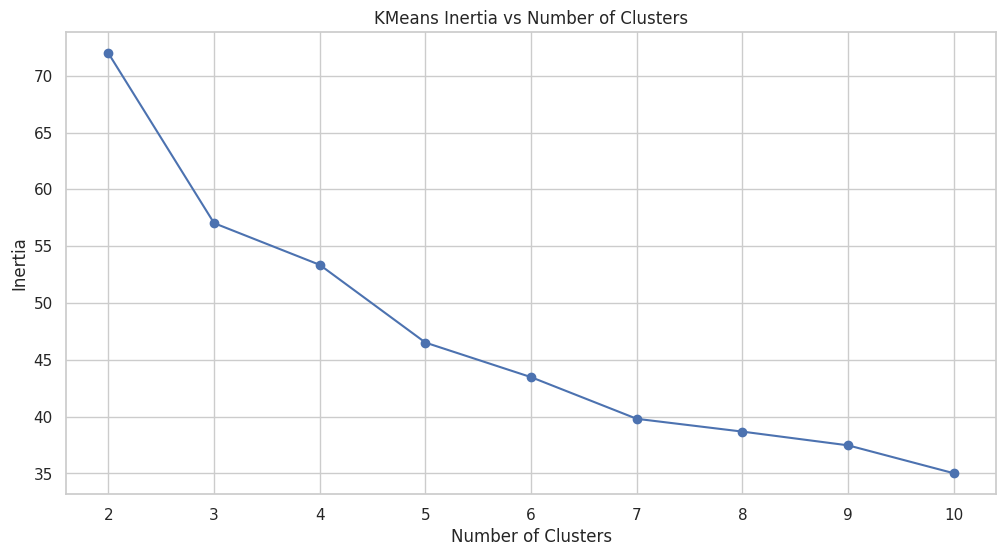

In [123]:
# cluster the features of `df_driver_scaled` using KMeans to see if any patterns emerge that impact lifetime_value
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# find the optimal number of clusters
inertia = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_driver_scaled)
    inertia.append(kmeans.inertia_)
    print(f'KMeans with {i} clusters has inertia: {kmeans.inertia_}')
    
plt.figure(figsize=(12, 6))
plt.plot(range(2, 11), inertia, marker='o')
plt.title('KMeans Inertia vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [124]:
# optimal k appears to be 7
kmeans = KMeans(n_clusters=7, random_state=42)
df_driver['cluster'] = kmeans.fit_predict(df_driver_scaled)
df_driver_scaled['cluster'] = kmeans.fit_predict(df_driver_scaled)
df_driver.head(2)

,avg_value_of_ride,lifetime_days,lifetime_value,avg_ride_distance,avg_ride_prime_time,avg_request_to_accept,avg_accept_to_arrive,avg_arrive_to_pickup,ride_count_per_day,cluster
driver_id,,,,,,,,,,
002be0ffdc997bd5c50703158b7c2491,9.700850,86,2687.135387,3.903841,19.404332,0.140132,2.883153,0.087184,3.220930,0
007f0389f9c7b03ef97098422f902e62,7.434851,85,230.480383,2.355818,20.161290,0.197312,2.952688,0.081183,0.364706,5


In [125]:
df_driver_avg_cluster_values = df_driver_scaled.groupby('cluster').mean()
df_driver_avg_cluster_values

,lifetime_value,avg_value_of_ride,avg_ride_distance,avg_ride_prime_time,avg_request_to_accept,avg_accept_to_arrive,avg_arrive_to_pickup,ride_count_per_day
cluster,,,,,,,,
0,0.285167,0.190505,0.133693,0.313474,0.165782,0.201086,0.788425,0.131315
1,0.066697,0.428304,0.345760,0.211898,0.214952,0.514450,0.714511,0.036393
2,0.085342,0.284186,0.223452,0.231901,0.559245,0.390235,0.756187,0.046702
3,0.042523,0.185194,0.141771,0.185067,0.148670,0.237294,0.768938,0.052699
4,0.411927,0.328302,0.253918,0.240551,0.244291,0.361699,0.780648,0.138782
5,0.052125,0.196843,0.131479,0.444469,0.149323,0.230529,0.747461,0.064530
6,0.571649,0.209257,0.145538,0.328355,0.164921,0.196002,0.795070,0.237805


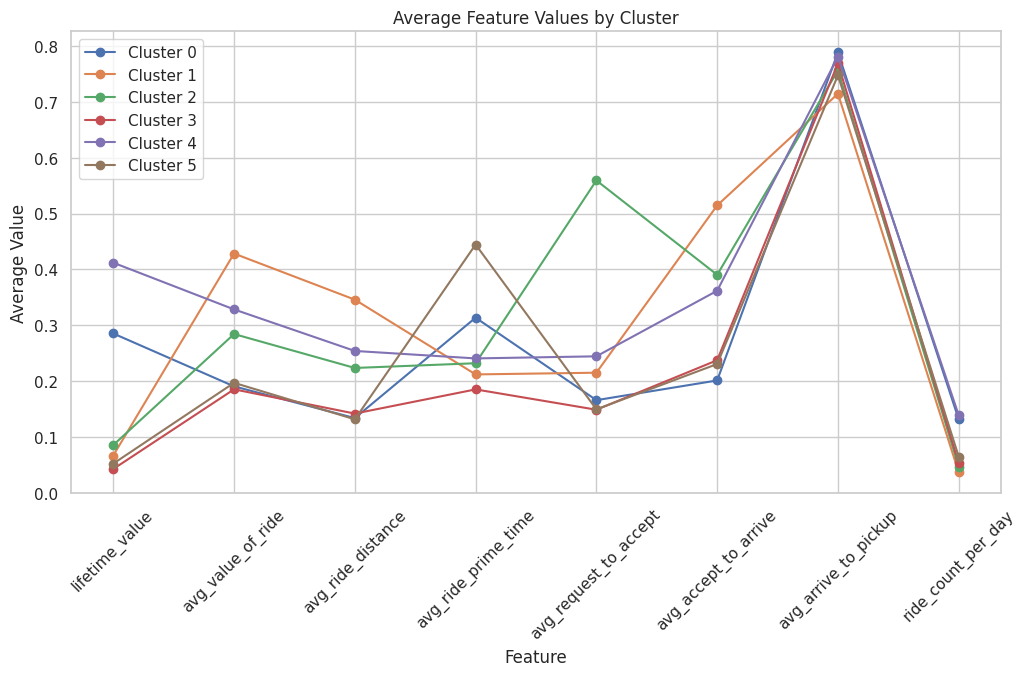

In [126]:
# create a plot with `df_driver_avg_cluster_values` with each feature name on the x-axis and a point for each feature value on the y-axis
plt.figure(figsize=(12, 6))
for cluster in range(6):
    plt.plot(df_driver_avg_cluster_values.columns, df_driver_avg_cluster_values.loc[cluster], marker='o', label=f'Cluster {cluster}')
plt.title('Average Feature Values by Cluster')
plt.xlabel('Feature')
plt.ylabel('Average Value')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [127]:
df_driver['cluster'].value_counts()

cluster
0    285
3    158
6    114
4     90
1     81
5     76
2     33
Name: count, dtype: int64

DBSCAN with eps=0.1 has silhouette score: -0.0725651277659756
DBSCAN with eps=0.2 has silhouette score: 0.675161111344074
DBSCAN with eps=0.3 has silhouette score: 0.744377111393756
DBSCAN with eps=0.4 has silhouette score: 0.7532000909699406
DBSCAN with eps=0.5 has silhouette score: 0.7566203595107456
DBSCAN with eps=0.6 has silhouette score: 0.7542278851210797
DBSCAN with eps=0.7 has silhouette score: 0.760863010778549
DBSCAN with eps=0.7999999999999999 has silhouette score: 0.760863010778549
DBSCAN with eps=0.8999999999999999 has silhouette score: 0.760863010778549
DBSCAN with eps=0.9999999999999999 has silhouette score: 0.760863010778549
DBSCAN with eps=1.0999999999999999 has silhouette score: 0
DBSCAN with eps=1.2 has silhouette score: 0
DBSCAN with eps=1.3 has silhouette score: 0
DBSCAN with eps=1.4 has silhouette score: 0
DBSCAN with eps=1.5 has silhouette score: 0
DBSCAN with eps=1.5999999999999999 has silhouette score: 0
DBSCAN with eps=1.7 has silhouette score: 0
DBSCAN with 

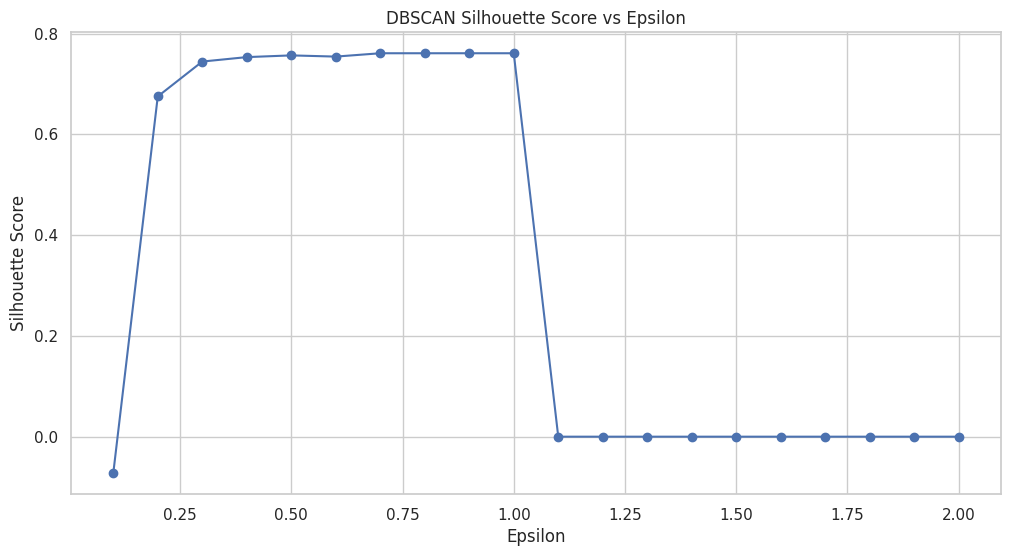

In [128]:
# cluster the features of `df_driver_scaled` using DBSCAN to see if any patterns emerge that impact lifetime_value
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# find the optimal eps value
silhouette_scores = []
eps_values = np.linspace(0.1, 2.0, 20)
for eps in eps_values:
    dbscan = DBSCAN(eps=eps)
    labels = dbscan.fit_predict(df_driver_scaled)
    if len(set(labels)) > 1:
        silhouette_scores.append(silhouette_score(df_driver_scaled, labels))
    else:
        silhouette_scores.append(0)
    print(f'DBSCAN with eps={eps} has silhouette score: {silhouette_scores[-1]}')
    
plt.figure(figsize=(12, 6))
plt.plot(eps_values, silhouette_scores, marker='o')
plt.title('DBSCAN Silhouette Score vs Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Silhouette Score')
plt.show()

In [129]:
# optimal eps appears to be 1.6
dbscan = DBSCAN(eps=1)
df_driver['cluster'] = dbscan.fit_predict(df_driver_scaled)
df_driver_scaled['cluster'] = dbscan.fit_predict(df_driver_scaled)
df_driver_scaled

,lifetime_value,avg_value_of_ride,avg_ride_distance,avg_ride_prime_time,avg_request_to_accept,avg_accept_to_arrive,avg_arrive_to_pickup,ride_count_per_day,cluster
driver_id,,,,,,,,,
002be0ffdc997bd5c50703158b7c2491,0.285478,0.181751,0.132614,0.338135,0.092900,0.117093,0.784625,0.090809,0
007f0389f9c7b03ef97098422f902e62,0.022358,0.036590,0.021907,0.351325,0.187658,0.123794,0.781431,0.009093,1
011e5c5dfc5c2c92501b8b24d47509bc,0.038045,0.270523,0.205862,0.345952,0.062136,0.197793,0.774490,0.012964,1
0152a2f305e71d26cc964f8d4411add9,0.222702,0.264982,0.195724,0.187030,0.252848,0.215931,0.787126,0.084041,0
01674381af7edd264113d4e6ed55ecda,0.461814,0.300595,0.223581,0.218403,0.206696,0.186956,0.811025,0.190242,2
...,...,...,...,...,...,...,...,...,...
ff419a3476e21e269e340b5f1f05414e,0.303060,0.315083,0.221122,0.223222,0.223499,0.287548,0.799286,0.112160,2
ff714a67ba8c6a108261cd81e3b77f3a,0.506086,0.187292,0.113162,0.309891,0.155096,0.126081,0.763852,0.169964,6
fff482c704d36a1afe8b8978d5486283,0.029659,0.106925,0.074848,0.087129,0.363357,0.208841,0.756731,0.028110,5


In [130]:
df_driver_scaled_cluster_values = df_driver_scaled.groupby('cluster').mean()
df_driver_scaled_cluster_values

,lifetime_value,avg_value_of_ride,avg_ride_distance,avg_ride_prime_time,avg_request_to_accept,avg_accept_to_arrive,avg_arrive_to_pickup,ride_count_per_day
cluster,,,,,,,,
0,0.285167,0.190505,0.133693,0.313474,0.165782,0.201086,0.788425,0.131315
1,0.052125,0.196843,0.131479,0.444469,0.149323,0.230529,0.747461,0.064530
2,0.411927,0.328302,0.253918,0.240551,0.244291,0.361699,0.780648,0.138782
3,0.066697,0.428304,0.345760,0.211898,0.214952,0.514450,0.714511,0.036393
4,0.085342,0.284186,0.223452,0.231901,0.559245,0.390235,0.756187,0.046702
5,0.042523,0.185194,0.141771,0.185067,0.148670,0.237294,0.768938,0.052699
6,0.571649,0.209257,0.145538,0.328355,0.164921,0.196002,0.795070,0.237805


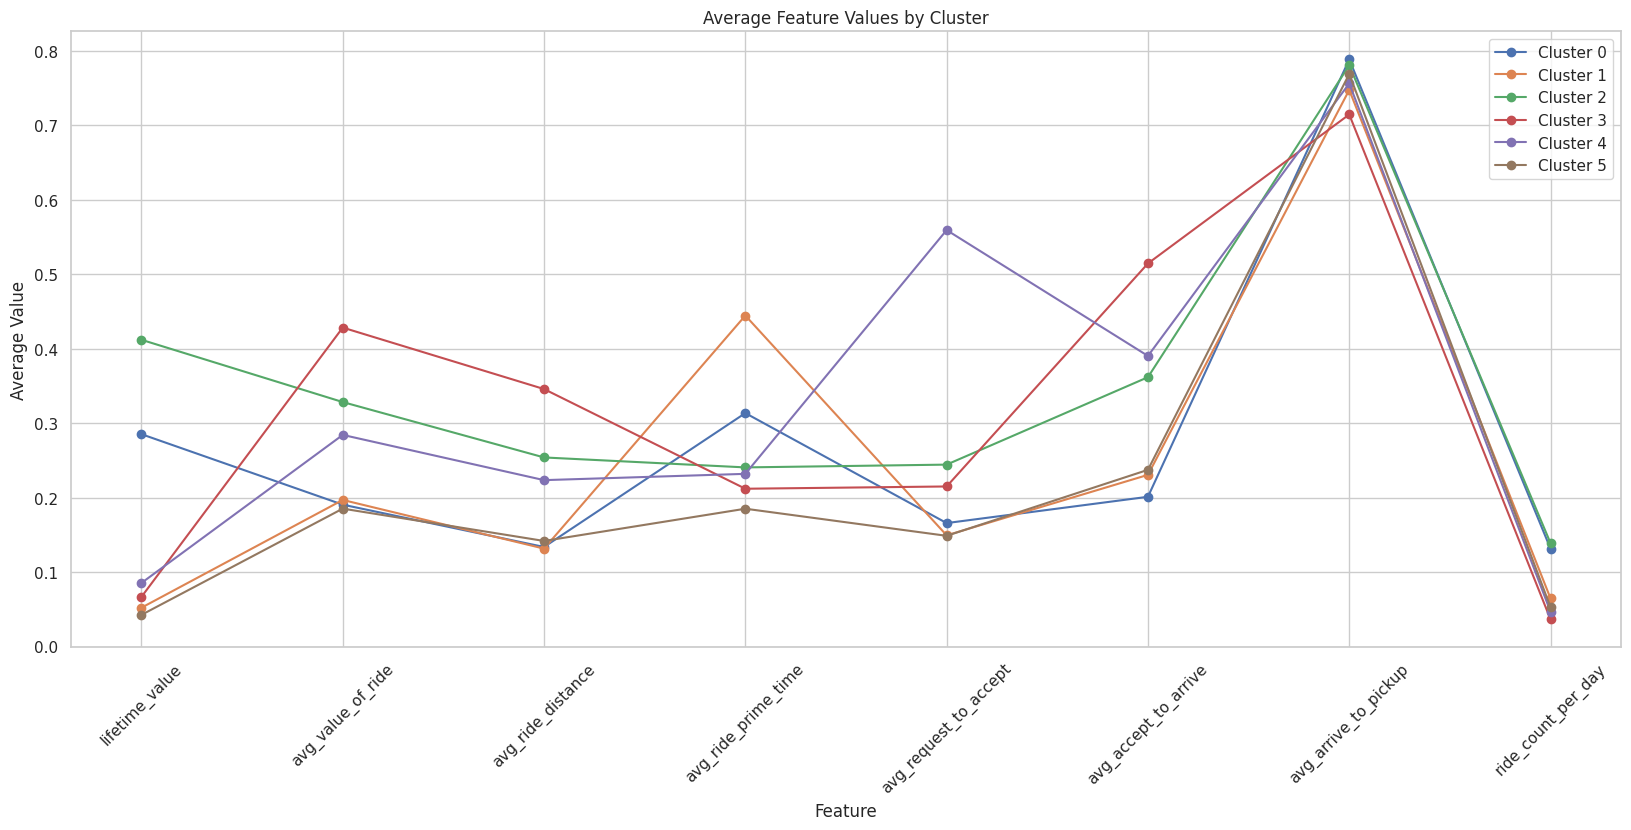

In [131]:
# create a plot with `df_driver_scaled_cluster_values` with each feature name on the x-axis and a point for each feature value on the y-axis
plt.figure(figsize=(20, 8))
for cluster in range(len(df_driver_scaled_cluster_values.index) -1):
    plt.plot(df_driver_scaled_cluster_values.columns, df_driver_scaled_cluster_values.loc[cluster], marker='o', label=f'Cluster {cluster}')
plt.title('Average Feature Values by Cluster')
plt.xlabel('Feature')
plt.ylabel('Average Value')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Actionable Recommendations:
1. Optimize value per month instead of lifetime value because, as you can see in the 'driver_onboard_date' histogram, drivers are continuously onboarding, which can skew the lifetime value.
2. Since Excellent drivers tend to take more rides per day, it is recommended for management to reward drivers who accept more rides per day.
3. Find out why Excellent and Good drivers ten to accept requests from drivers quicker than Fair and Bad drivers
4. Excellent drivers tend to have a shorter arrive to pick up time. This may indicate that better drivers are more familiar with the city and know how to navigate it better. It is recommended to improve algorithms that help drivers find their riders more easily.